## Breast Cancer detection with neural networks
This notebook contains an example of classification, using neural networks aiming to detect the severity of breast cancer on the dataset

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from pprint import pprint
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## The dataset
This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg.


In [24]:
# Importing data
data_csv = "../breast-cancer-wisconsin.csv"
df = pd.read_csv(data_csv, names=['ID','Clump','U_Cell_size','U_Cell_shape','Marginal_Adhesion','SE_epitelial_cell_size','Bare_nuclei','bland_chromatin','Normal_Nucleoli','Mitoses','Class'])
df.head()

,ID,Clump,U_Cell_size,U_Cell_shape,Marginal_Adhesion,SE_epitelial_cell_size,Bare_nuclei,bland_chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [25]:
df.dtypes

ID                         int64
Clump                      int64
U_Cell_size                int64
U_Cell_shape               int64
Marginal_Adhesion          int64
SE_epitelial_cell_size     int64
Bare_nuclei               object
bland_chromatin            int64
Normal_Nucleoli            int64
Mitoses                    int64
Class                      int64
dtype: object

In [26]:
# Change bare nuclei values to numeric only and check the numbers of NAN
df['Bare_nuclei'] = pd.to_numeric(df['Bare_nuclei'], errors='coerce')
print(df['Bare_nuclei'].isnull().values.sum())

# Drop the lines with null values
df = df.dropna()
print(df['Bare_nuclei'].isnull().values.sum())

16
0


#  Attribute                     Domain
-- -----------------------------------------
1. Sample code number            id number
2. Clump Thickness               1 - 10
3. Uniformity of Cell Size       1 - 10
4. Uniformity of Cell Shape      1 - 10
5. Marginal Adhesion             1 - 10
6. Single Epithelial Cell Size   1 - 10
7. Bare Nuclei                   1 - 10
8. Bland Chromatin               1 - 10
9. Normal Nucleoli               1 - 10
10. Mitoses                       1 - 10
11. Class:                        (2 for benign, 4 for malignant)

## Check the number of occurences of both types of cancer

In [27]:
print(f"Total     = {len(df)} -> 100%")
print(f"Benign    = {len(df[df.Class == 2])} -> {len(df[df.Class == 2])/len(df) *100}%")
print(f"Malignant = {len(df[df.Class == 4])} -> {len(df[df.Class == 4])/len(df) *100}%")
from sklearn import preprocessing

Total     = 683 -> 100%
Benign    = 444 -> 65.00732064421669%
Malignant = 239 -> 34.99267935578331%


## Normalize the dataset

In [28]:
dataset = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
dataset_scaled = min_max_scaler.fit_transform(dataset)
df = pd.DataFrame(dataset_scaled)
df.head()
dataset = df.values #returns a numpy array

# Divide dataset into features and labels
x = dataset[:, 0:10].astype(float)
y = dataset[:, 10:11]

In [29]:
# Spliting data
seed = 9
# Split data set into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.15, random_state=seed
)
# Split train into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.175, random_state=seed
)

In [30]:
# Dataset dataframe
class_1 = [len(np.where(y_train[:,0]==0)[0]),len(np.where(y_val[:,0]==0)[0]),len(np.where(y_test[:,0]==0)[0])]
class_1.append(np.sum(class_1))
class_2 = [len(np.where(y_train[:,0]==1)[0]),len(np.where(y_val[:,0]==1)[0]),len(np.where(y_test[:,0]==1)[0])]
class_2.append(np.sum(class_2))
total   = [len(y_train[:,0]),len(y_val[:,0]),len(y_test[:,0])]
total.append(np.sum(total))

table_df = {'Dataset': ['Training','Validation','Test','Total'],'Porcent':[60,20,20,100], 'Class 1': class_1,'Class 2': class_2,'Total':total}
table_df = pd.DataFrame(data=table_df)
table_df.to_csv('divisão_de_dados')
table_df.head()

,Dataset,Porcent,Class 1,Class 2,Total
0,Training,60,314,164,478
1,Validation,20,60,43,103
2,Test,20,70,32,102
3,Total,100,444,239,683


In [20]:
# Building the NN
lr = 0.001  # learning rate
lr_decay = 0.0005# learning rate decay
n_mini_batch = 100  # mini-batch length
activation_fcn = "sigmoid"
optimizer = Adam(lr=lr, decay=lr_decay)
input_dim = x.shape[1]
h_n = 30
model = Sequential()
model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

# Train and validate the model
history = model.fit(
    x_train,
    y_train[:, 0],
    validation_data=(x_val, y_val[:, 0]),
    epochs=200,
    batch_size=50,
    # verbose=0,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1
        )
    ],
)

pred = model.predict(x_test)
pred = np.array(pred).flatten()
erro = pred - np.array(y_test[:, 0]).flatten()
erro = np.abs(erro)

acerto = 0
for i in erro:
    if i < 0.5:
        acerto += 1

best_pred = pred

Epoch 1/200
10/10 [==============================] - 2s 68ms/step - loss: 0.3645 - accuracy: 0.6911 - val_loss: 0.3747 - val_accuracy: 0.5825
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2823 - accuracy: 0.6672 - val_loss: 0.2883 - val_accuracy: 0.5825
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2384 - accuracy: 0.6789 - val_loss: 0.2540 - val_accuracy: 0.5825
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.6667 - val_loss: 0.2318 - val_accuracy: 0.6019
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 0.2128 - accuracy: 0.6700 - val_loss: 0.2133 - val_accuracy: 0.6117
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 0.1952 - accuracy: 0.6671 - val_loss: 0.1968 - val_accuracy: 0.6311
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 0.1750 - accuracy: 0.6937 - val_loss: 0.1798 - val_accuracy: 0.6796
Epoch 8/200


Epoch 59/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9680 - val_loss: 0.0338 - val_accuracy: 0.9709
Epoch 60/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9766 - val_loss: 0.0338 - val_accuracy: 0.9709
Epoch 61/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0356 - accuracy: 0.9732 - val_loss: 0.0335 - val_accuracy: 0.9709
Epoch 62/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0359 - accuracy: 0.9730 - val_loss: 0.0335 - val_accuracy: 0.9709
Epoch 63/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0414 - accuracy: 0.9590 - val_loss: 0.0337 - val_accuracy: 0.9709
Epoch 64/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0401 - accuracy: 0.9604 - val_loss: 0.0336 - val_accuracy: 0.9709
Epoch 65/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0374 - accuracy: 0.9631 - val_loss: 0.0331 - val_accuracy: 0.9709
Epoch 

10/10 [==============================] - 0s 4ms/step - loss: 0.0352 - accuracy: 0.9662 - val_loss: 0.0296 - val_accuracy: 0.9709
Epoch 117/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0347 - accuracy: 0.9619 - val_loss: 0.0293 - val_accuracy: 0.9709
Epoch 118/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0364 - accuracy: 0.9689 - val_loss: 0.0297 - val_accuracy: 0.9709
Epoch 119/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9763 - val_loss: 0.0295 - val_accuracy: 0.9709
Epoch 120/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9735 - val_loss: 0.0293 - val_accuracy: 0.9709
Epoch 121/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0294 - accuracy: 0.9758 - val_loss: 0.0292 - val_accuracy: 0.9709
Epoch 122/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.9665 - val_loss: 0.0295 - val_accuracy: 0.9709
Epoch 123/200

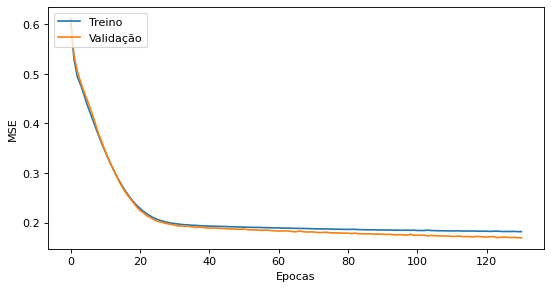

In [31]:
# Plot the validation and train loss
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.ylabel("MSE")
plt.xlabel("Epocas")
plt.legend(["Treino", "Validação"], loc="upper left")
plt.show()

In [32]:
def get_confusion_matrix(reais, preditos, labels):
    """
    Uma função que retorna a matriz de confusão para uma classificação binária
    
    Args:
        reais (list): lista de valores reais
        preditos (list): lista de valores preditos pelo modelos
        labels (list): lista de labels a serem avaliados.
            É importante que ela esteja presente, pois usaremos ela para entender
            quem é a classe positiva e quem é a classe negativa
    
    Returns:
        Um numpy.array, no formato:
            numpy.array([
                [ tp, fp ],
                [ fn, tn ]
            ])
    """
    # não implementado
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = labels[0]
    negative_class = labels[1]

    # valores preditos corretamente
    tp = 0
    tn = 0
    
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])

## Confusion Matrix

In [37]:
valores_reais = np.array(y_test[:,0],dtype=int).flatten()
valores_preditos = np.array(np.round(pred),dtype=int).flatten()
matrix = get_confusion_matrix(reais=valores_reais, preditos=valores_preditos, labels=[1,0])
matrix_df = {'True_positive': matrix[0]}
print(matrix_df)

{'True_positive': array([31,  1])}


## Finding out the best number of neurons on the hidden layer

In [34]:
# Testing different number of neurons
neurons = [5,10,15,30]
repetitions = 2
result = list()
for neuron in neurons:
    result_i = list()
    for i in range(0,repetitions):
        lr = 0.001  # learning rate
        lr_decay = 0.0005# learning rate decay
        n_mini_batch = 100  # mini-batch length
        activation_fcn = "sigmoid"
        optimizer = Adam(lr=lr, decay=lr_decay)
        input_dim = x.shape[1]
        h_n = neuron
        model = Sequential()
        model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
        model.add(Dense(1, activation="linear"))

        # Compile model
        model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

        # Train and validate the model
        history = model.fit(
            x_train,
            y_train[:, 0],
            validation_data=(x_val, y_val[:, 0]),
            epochs=200,
            batch_size=30,
            # verbose=0,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1
                )
            ],
        )
        pred = model.predict(x_test)
        pred = np.array(pred).flatten()

        erro = pred - np.array(y_test[:, 0]).flatten()
        erro = np.abs(erro)

        acerto = 0
        for i in erro:
            if i < 0.5:
                acerto += 1

        result_i.append(acerto)
    result.append(result_i)

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.5223 - accuracy: 0.3431 - val_loss: 0.4078 - val_accuracy: 0.4175
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4434 - accuracy: 0.3527 - val_loss: 0.3532 - val_accuracy: 0.4175
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3913 - accuracy: 0.3315 - val_loss: 0.3082 - val_accuracy: 0.4175
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3315 - accuracy: 0.3531 - val_loss: 0.2707 - val_accuracy: 0.4078
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.3410 - val_loss: 0.2388 - val_accuracy: 0.4078
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2578 - accuracy: 0.3492 - val_loss: 0.2116 - val_accuracy: 0.4951
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.4742 - val_loss: 0.1882 - val_accuracy: 0.7476
Epoch 8/200
1

Epoch 59/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.9685 - val_loss: 0.0234 - val_accuracy: 0.9806
Epoch 60/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9606 - val_loss: 0.0233 - val_accuracy: 0.9806
Epoch 61/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9690 - val_loss: 0.0233 - val_accuracy: 0.9806
Epoch 62/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9505 - val_loss: 0.0230 - val_accuracy: 0.9806
Epoch 63/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9723 - val_loss: 0.0230 - val_accuracy: 0.9806
Epoch 64/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9661 - val_loss: 0.0230 - val_accuracy: 0.9806
Epoch 65/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9720 - val_loss: 0.0229 - val_accuracy: 0.9806
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.6464 - val_loss: 0.2754 - val_accuracy: 0.5825
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.6452 - val_loss: 0.2353 - val_accuracy: 0.6019
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1881 - accuracy: 0.6630 - val_loss: 0.2051 - val_accuracy: 0.6117
Epoch 9/200
16/16 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.6979 - val_loss: 0.1810 - val_accuracy: 0.6408
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1521 - accuracy: 0.7090 - val_loss: 0.1616 - val_accuracy: 0.6796
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1316 - accuracy: 0.7570 - val_loss: 0.1470 - val_accuracy: 0.7184
Epoch 12/200
16/16 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.8095 - val_loss: 0.1360 - val_accuracy: 0.7767
Epoch 13/200
16/16 [==

Epoch 64/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0347 - accuracy: 0.9711 - val_loss: 0.0302 - val_accuracy: 0.9709
Epoch 65/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9628 - val_loss: 0.0300 - val_accuracy: 0.9709
Epoch 66/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9495 - val_loss: 0.0296 - val_accuracy: 0.9709
Epoch 67/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9707 - val_loss: 0.0292 - val_accuracy: 0.9709
Epoch 68/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9697 - val_loss: 0.0289 - val_accuracy: 0.9709
Epoch 69/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 0.9664 - val_loss: 0.0287 - val_accuracy: 0.9709
Epoch 70/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9547 - val_loss: 0.0285 - val_accuracy: 0.9709
Epoch 

16/16 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.9601 - val_loss: 0.0226 - val_accuracy: 0.9806
Epoch 122/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0301 - accuracy: 0.9752 - val_loss: 0.0226 - val_accuracy: 0.9806
Epoch 123/200
16/16 [==============================] - 0s 4ms/step - loss: 0.0323 - accuracy: 0.9709 - val_loss: 0.0226 - val_accuracy: 0.9806
Epoch 124/200
16/16 [==============================] - 0s 4ms/step - loss: 0.0325 - accuracy: 0.9653 - val_loss: 0.0225 - val_accuracy: 0.9806
Epoch 125/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0278 - accuracy: 0.9724 - val_loss: 0.0224 - val_accuracy: 0.9806
Epoch 126/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9729 - val_loss: 0.0224 - val_accuracy: 0.9806
Epoch 127/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9629 - val_loss: 0.0223 - val_accuracy: 0.9806
Epoch 128/200

16/16 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9704 - val_loss: 0.0317 - val_accuracy: 0.9709
Epoch 35/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9574 - val_loss: 0.0318 - val_accuracy: 0.9709
Epoch 36/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0380 - accuracy: 0.9593 - val_loss: 0.0315 - val_accuracy: 0.9709
Epoch 37/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0398 - accuracy: 0.9588 - val_loss: 0.0315 - val_accuracy: 0.9709
Epoch 38/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9718 - val_loss: 0.0314 - val_accuracy: 0.9709
Epoch 39/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9651 - val_loss: 0.0313 - val_accuracy: 0.9709
Epoch 40/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9737 - val_loss: 0.0312 - val_accuracy: 0.9709
Epoch 41/200
16/16 

Epoch 92/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9672 - val_loss: 0.0282 - val_accuracy: 0.9709
Epoch 93/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9767 - val_loss: 0.0282 - val_accuracy: 0.9709
Epoch 94/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9817 - val_loss: 0.0281 - val_accuracy: 0.9709
Epoch 95/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9733 - val_loss: 0.0280 - val_accuracy: 0.9709
Epoch 96/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9686 - val_loss: 0.0280 - val_accuracy: 0.9709
Epoch 97/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9661 - val_loss: 0.0279 - val_accuracy: 0.9709
Epoch 98/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9716 - val_loss: 0.0278 - val_accuracy: 0.9709
Epoch 

16/16 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9141 - val_loss: 0.1072 - val_accuracy: 0.9126
Epoch 16/200
16/16 [==============================] - 0s 3ms/step - loss: 0.1008 - accuracy: 0.9312 - val_loss: 0.1012 - val_accuracy: 0.9515
Epoch 17/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0998 - accuracy: 0.9379 - val_loss: 0.0958 - val_accuracy: 0.9709
Epoch 18/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0884 - accuracy: 0.9608 - val_loss: 0.0911 - val_accuracy: 0.9709
Epoch 19/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0877 - accuracy: 0.9422 - val_loss: 0.0858 - val_accuracy: 0.9709
Epoch 20/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9509 - val_loss: 0.0816 - val_accuracy: 0.9709
Epoch 21/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9601 - val_loss: 0.0775 - val_accuracy: 0.9709
Epoch 22/200
16/16 

Epoch 73/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9789 - val_loss: 0.0287 - val_accuracy: 0.9806
Epoch 74/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9763 - val_loss: 0.0286 - val_accuracy: 0.9806
Epoch 75/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9674 - val_loss: 0.0285 - val_accuracy: 0.9806
Epoch 76/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9811 - val_loss: 0.0286 - val_accuracy: 0.9806
Epoch 77/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9771 - val_loss: 0.0285 - val_accuracy: 0.9806
Epoch 78/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9854 - val_loss: 0.0285 - val_accuracy: 0.9806
Epoch 79/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9783 - val_loss: 0.0283 - val_accuracy: 0.9806
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9688 - val_loss: 0.0308 - val_accuracy: 0.9709
Epoch 43/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0322 - accuracy: 0.9578 - val_loss: 0.0306 - val_accuracy: 0.9709
Epoch 44/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9606 - val_loss: 0.0305 - val_accuracy: 0.9709
Epoch 45/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0345 - accuracy: 0.9604 - val_loss: 0.0304 - val_accuracy: 0.9709
Epoch 46/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.9559 - val_loss: 0.0302 - val_accuracy: 0.9709
Epoch 47/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9465 - val_loss: 0.0300 - val_accuracy: 0.9709
Epoch 48/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.9612 - val_loss: 0.0299 - val_accuracy: 0.9709
Epoch 49/200
16/16 

Epoch 100/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 0.9658 - val_loss: 0.0252 - val_accuracy: 0.9709
Epoch 101/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9714 - val_loss: 0.0252 - val_accuracy: 0.9709
Epoch 102/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9622 - val_loss: 0.0250 - val_accuracy: 0.9709
Epoch 103/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.9623 - val_loss: 0.0250 - val_accuracy: 0.9709
Epoch 104/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9496 - val_loss: 0.0250 - val_accuracy: 0.9709
Epoch 105/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9655 - val_loss: 0.0248 - val_accuracy: 0.9709
Epoch 106/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9496 - val_loss: 0.0248 - val_accuracy: 0.9709

16/16 [==============================] - 0s 2ms/step - loss: 0.0433 - accuracy: 0.9574 - val_loss: 0.0377 - val_accuracy: 0.9612
Epoch 20/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9521 - val_loss: 0.0369 - val_accuracy: 0.9612
Epoch 21/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9551 - val_loss: 0.0361 - val_accuracy: 0.9612
Epoch 22/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0434 - accuracy: 0.9504 - val_loss: 0.0356 - val_accuracy: 0.9612
Epoch 23/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9471 - val_loss: 0.0355 - val_accuracy: 0.9612
Epoch 24/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.9623 - val_loss: 0.0349 - val_accuracy: 0.9612
Epoch 25/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9595 - val_loss: 0.0347 - val_accuracy: 0.9612
Epoch 26/200
16/16 

Epoch 77/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9690 - val_loss: 0.0286 - val_accuracy: 0.9709
Epoch 78/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9592 - val_loss: 0.0282 - val_accuracy: 0.9709
Epoch 79/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9695 - val_loss: 0.0283 - val_accuracy: 0.9709
Epoch 80/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9637 - val_loss: 0.0281 - val_accuracy: 0.9709
Epoch 81/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9767 - val_loss: 0.0282 - val_accuracy: 0.9709
Epoch 82/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9660 - val_loss: 0.0281 - val_accuracy: 0.9709
Epoch 83/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.9735 - val_loss: 0.0279 - val_accuracy: 0.9709
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9608 - val_loss: 0.0341 - val_accuracy: 0.9709
Epoch 43/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9513 - val_loss: 0.0340 - val_accuracy: 0.9709
Epoch 44/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9671 - val_loss: 0.0339 - val_accuracy: 0.9709
Epoch 45/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9656 - val_loss: 0.0338 - val_accuracy: 0.9709
Epoch 46/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9642 - val_loss: 0.0338 - val_accuracy: 0.9709
Epoch 47/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9556 - val_loss: 0.0337 - val_accuracy: 0.9709
Epoch 48/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 0.9634 - val_loss: 0.0336 - val_accuracy: 0.9709
Epoch 49/200
16/16 

16/16 [==============================] - 0s 2ms/step - loss: 0.0370 - accuracy: 0.9606 - val_loss: 0.0343 - val_accuracy: 0.9709
Epoch 27/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9443 - val_loss: 0.0341 - val_accuracy: 0.9709
Epoch 28/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9678 - val_loss: 0.0342 - val_accuracy: 0.9709
Epoch 29/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9659 - val_loss: 0.0342 - val_accuracy: 0.9709
Epoch 30/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0403 - accuracy: 0.9614 - val_loss: 0.0341 - val_accuracy: 0.9709
Epoch 31/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0406 - accuracy: 0.9514 - val_loss: 0.0336 - val_accuracy: 0.9709
Epoch 32/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0378 - accuracy: 0.9576 - val_loss: 0.0337 - val_accuracy: 0.9709
Epoch 33/200
16/16 

Epoch 84/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9687 - val_loss: 0.0299 - val_accuracy: 0.9709
Epoch 85/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.9587 - val_loss: 0.0297 - val_accuracy: 0.9709
Epoch 86/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9676 - val_loss: 0.0299 - val_accuracy: 0.9709
Epoch 87/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9518 - val_loss: 0.0296 - val_accuracy: 0.9709
Epoch 88/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9599 - val_loss: 0.0298 - val_accuracy: 0.9709
Epoch 89/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9669 - val_loss: 0.0296 - val_accuracy: 0.9709
Epoch 90/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9611 - val_loss: 0.0299 - val_accuracy: 0.9709
Epoch 

In [35]:
result = np.array(result).reshape((len(neurons),repetitions))

In [36]:
mean = [np.mean(i) for i in result]
acc  = np.array(result) * (100/len(y_val)) 
mean_acc = np.array(mean) * (100/len(y_val))

result_dict = {'neurons': neurons, 'results_1': result[:,0],'results_2':result[:,1], 'mean': mean, 'acc_1' : acc[:,0],'acc_2' : acc[:,1] , 'mean_acc': mean_acc}
result_df = pd.DataFrame(data=result_dict)
result_df

,neurons,results_1,results_2,mean,acc_1,acc_2,mean_acc
0,5,100,98,99.0,97.087379,95.145631,96.116505
1,10,99,99,99.0,96.116505,96.116505,96.116505
2,15,99,99,99.0,96.116505,96.116505,96.116505
3,30,99,99,99.0,96.116505,96.116505,96.116505
